<a href="https://colab.research.google.com/github/liveness-detection-bangkit-team/liveness_ai/blob/main/blink_MobilenetV2_ariel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from google.colab import files

In [53]:
MODEL_NAME = "blink_MobilenetV2_ariel2"
FILE_FORMAT = ".h5"

In [6]:
directory = "/content/drive/MyDrive/Assignment/Bangkit/Capstone/Liveness_Detection/datasets/pictures/blink"

In [20]:
seed_init = 42
IMAGE_SIZE = (224, 224)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    seed = seed_init,
    directory= directory,
    batch_size= 32,
    image_size= IMAGE_SIZE,
    shuffle = True,
    subset = 'training',
    validation_split = 0.2,
    label_mode= 'binary',
)


validation_dataset = tf.keras.utils.image_dataset_from_directory(
    seed = seed_init,
    directory= directory,
    batch_size= 32,
    image_size= IMAGE_SIZE,
    shuffle = True,
    subset= 'validation',
    validation_split = 0.2,
		label_mode= 'binary',
)


Found 2069 files belonging to 2 classes.
Using 1656 files for training.
Found 2069 files belonging to 2 classes.
Using 413 files for validation.


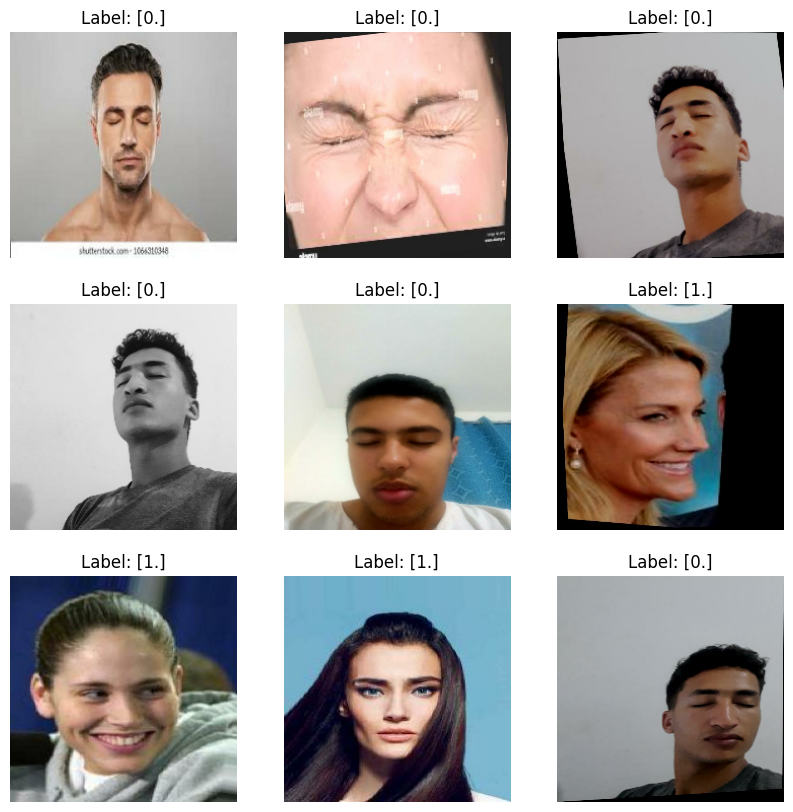

In [21]:
from google.colab.patches import cv2_imshow

for images, labels in train_dataset.take(1):  # Take the first batch
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display the first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()

In [22]:
# Optimize the datasets for training
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset = (train_dataset
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       )


validation_dataset = (validation_dataset
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )


In [23]:
IMG_SHAPE = IMAGE_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [24]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [25]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [26]:
base_model.trainable = False

In [27]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
inputs = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.F1Score(name='f1-score')])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_318CLONE (InputLayer)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=5,
    restore_best_weights=True
    )

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "./MobileNetV2" + MODEL_NAME + ".weights.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True
    )

#history = model.fit(train_dataset, epochs=25, callbacks=[early_stopping,checkpoint], validation_data=validation_dataset)
history = model.fit(train_dataset, epochs=25, validation_data=validation_dataset, callbacks=[early_stopping,checkpoint])

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6435 - f1-score: 0.6074 - loss: 0.8366 - precision: 0.5946 - recall: 0.5740
Epoch 1: val_accuracy improved from -inf to 0.86925, saving model to ./MobileNetV2Liveness.weights.h5
52/52 ━━━━━━━━━━━━━━━━━━━━ 106s 955ms/step - accuracy: 0.6451 - f1-score: 0.6078 - loss: 0.8320 - precision: 0.5968 - recall: 0.5763 - val_accuracy: 0.8692 - val_f1-score: 0.6805 - val_loss: 0.3236 - val_precision: 0.8664 - val_recall: 0.8826
Epoch 2/25
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8650 - f1-score: 0.6099 - loss: 0.3321 - precision: 0.8258 - recall: 0.8748
Epoch 2: val_accuracy improved from 0.86925 to 0.90073, saving model to ./MobileNetV2Liveness.weights.h5
52/52 ━━━━━━━━━━━━━━━━━━━━ 44s 43ms/step - accuracy: 0.8653 - f1-score: 0.6105 - loss: 0.3315 - precision: 0.8268 - recall: 0.8749 - val_accuracy: 0.9007 - val_f1-score: 0.6805 - val_loss: 0.2755 - val_precision: 0.8613 - val_recall: 0.9624
Epoch 3/25
51/52 ━━━━━━━━━━━━━━━━━━━━

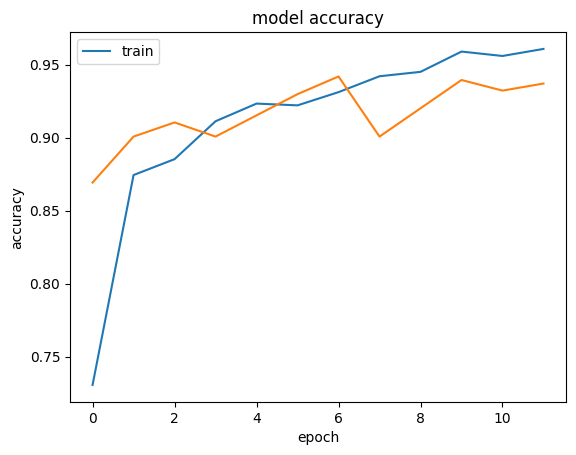

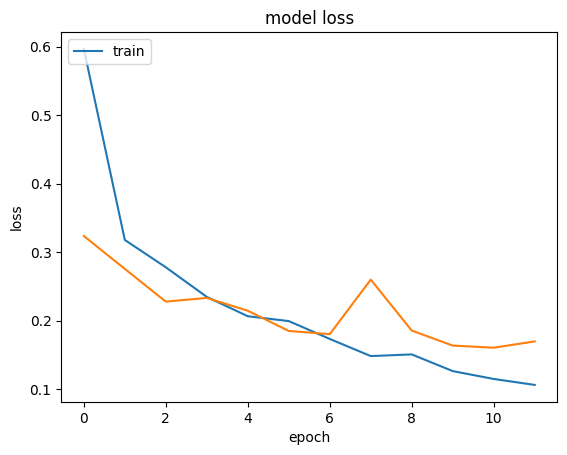

In [30]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train"], loc="upper left")
    plt.show()

    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train"], loc="upper left")
    plt.show()

    plt.show()

plot_loss_acc(history)

In [ ]:
#model.save("/content/drive/MyDrive/Learning/Bootcamp/Bangkit/Machine Learning/Liveness Detection/training_model/MobileNetV2Liveness[final].h5")

In [54]:
model.save(os.path.join(MODEL_NAME + FILE_FORMAT))

In [55]:
files.download(os.path.join(MODEL_NAME + FILE_FORMAT))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
loaded_model = tf.keras.models.load_model("./blink_MobilenetV2_ariel2.h5")

In [35]:
loaded_model.evaluate(validation_dataset)

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.9195 - f1-score: 0.6845 - loss: 0.1992 - precision: 0.9049 - recall: 0.9461


[0.18024270236492157,
 0.9418886303901672,
 0.931506872177124,
 0.9577465057373047,
 0.6805111169815063]

Saving WhatsApp Image 2024-11-15 at 08.19.53_03527be0.jpg to WhatsApp Image 2024-11-15 at 08.19.53_03527be0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[0.12537703]]
0
closed


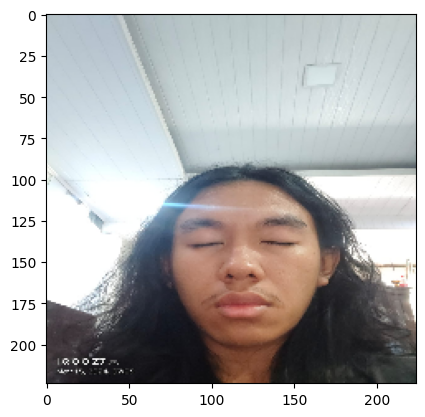

In [36]:
from google.colab import files

image = tf.keras.preprocessing.image

uploaded = files.upload()
for fn in uploaded.keys():
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224,224))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  #x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
  images = np.vstack([x])
  #classes = model.predict(images)
  classes = loaded_model.predict(images)
  #print(fn)
  prediction = 1 if classes[0] >= 0.5 else 0
  print(classes)
  print(prediction)
  #print(classes)
  if prediction == 0:
    print('closed')
  elif prediction == 1:
    print('opened')
  else:
    print('something wrong')

Saving 000286_jpg.rf.e17eb5e5ffa5351813c2a4b3d0cc4c3f.jpg to 000286_jpg.rf.e17eb5e5ffa5351813c2a4b3d0cc4c3f.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[0.9872593]]
1
opened


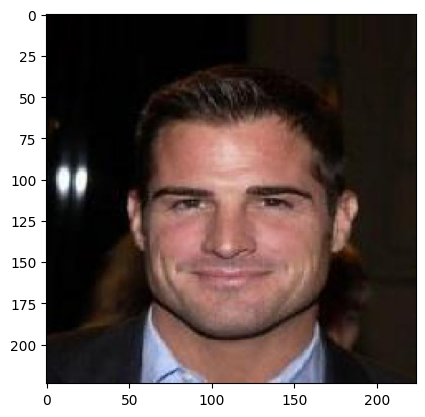

In [51]:


image = tf.keras.preprocessing.image

uploaded = files.upload()
for fn in uploaded.keys():
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224,224))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  #x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
  images = np.vstack([x])
  #classes = model.predict(images)
  classes = loaded_model.predict(images)
  #print(fn)
  prediction = 1 if classes[0] >= 0.5 else 0
  print(classes)
  print(prediction)
  #print(classes)
  if prediction == 0:
    print('closed')
  elif prediction == 1:
    print('opened')
  else:
    print('something wrong')

In [ ]:
# Create the widget and take care of the display
from ipywidgets import widgets
from io import BytesIO
import base64
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""
    image = tf.keras.utils.load_img(file, target_size=(225, 225))
    image = tf.keras.utils.img_to_array(image)
    image = np.expand_dims(image, axis=0)

    prediction = loaded_model.predict(image, verbose=0)[0]

    with out:

        print(f'\nmodel output: {prediction}')

        prediction_index = np.argmax(prediction)

        classes = ["closed", "opened"]

        predicted_class = classes[prediction_index]

        print(f'{filename} is {predicted_class}')


def on_upload_change(change):
    """ A function for geting files from the widget and running the prediction."""
    # Get the newly uploaded file(s)
    items = change.new
    for filename, (content, metadata) in items.items(): # Loop if there is more than one file uploaded
        content_bytes = base64.b64decode(content) # Decode the content string
        file_jpgdata = BytesIO(content_bytes) # Encode the content string to bytes
        file_predict(filename, file_jpgdata, out)
    """
    items = change.new
    for item in items: # Loop if there is more than one file uploaded
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)
    """

uploader.observe(on_upload_change, names='value')

FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Output()

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7ba873395940>